In [ ]:
! pip install nltk
! pip install matplotlib
! pip install scikit-learn
! pip install pandas
! pip install transformers
! pip install gensim
! pip install scipy
! pip install langdetect
! pip install bertopic
! pip install spacy
! python -m spacy download en_core_web_md
! pip install kneed
! pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=545ee3a7193d7f58c565bd6dde52a4e5081d8e2ec41baace8b35ebbd979e800b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310

# Pre processamento

In [ ]:
import pandas as pd
import nltk
import json
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import words

In [ ]:
df = pd.read_csv('./commits20.csv')
with open('./projects.json', 'r') as f:
  data = json.load(f)


In [ ]:
df_data = []
total_projs = []
for i, item in enumerate(data):
    lang = item["lang"]
    repos = item["repos"]
    for repo_info in item["repo"]:
        repo_name = repo_info["name"]
        stars = repo_info["stars"]
        total_projs.append(repo_name)
        df_data.append({"lang": lang, "repos": repos, "repo_name": repo_name, "stars": stars})
df_data = pd.DataFrame(df_data)
df_data['repo_name'] = df_data['repo_name'].drop_duplicates(keep='first')

juntando dados do projeto e linguagem com os commits

In [ ]:
df_original = pd.DataFrame(df)
df_resultado = df_data.merge(df_original, left_on="repo_name", right_on="project", how="left")
df_resultado.head()

lang   repos                  repo_name   stars  \
0  JavaScript  387469  freeCodeCamp/freeCodeCamp  307799   
1  JavaScript  387469                  vuejs/vue  154667   
2  JavaScript  387469                  vuejs/vue  154667   
3  JavaScript  387469                  vuejs/vue  154667   
4  JavaScript  387469                  vuejs/vue  154667   

                                             message    project      name  \
0                                                NaN        NaN       NaN   
1                                 release: v2.7.14\n  vuejs/vue  Evan You   
2  fix(provide/inject): do not mutate original pr...  vuejs/vue  Evan You   
3  fix(reactivity): avoid using WeakMap for IE co...  vuejs/vue  Evan You   
4                   test: add test case for #12778\n  vuejs/vue  Evan You   

     author                                            subject  
0       NaN                                                NaN  
1  Evan You                                   release: v2.7.14  
2  Evan You  fix(provide/inject): do not mutate original pr...  
3  Evan You  fix(reactivity): avoid using WeakMap for IE co...  
4  Evan You                     test: add test case for #12778

removendo valores vazios

In [ ]:
print(df_resultado.isna().sum())
df_resultado = df_resultado.dropna()
print(df_resultado.isna().sum())
df_resultado.head()

lang          0
repos         0
repo_name     0
stars         0
message      47
project      45
name         50
author       50
subject      58
dtype: int64
lang         0
repos        0
repo_name    0
stars        0
message      0
project      0
name         0
author       0
subject      0
dtype: int64


lang   repos  repo_name   stars  \
1  JavaScript  387469  vuejs/vue  154667   
2  JavaScript  387469  vuejs/vue  154667   
3  JavaScript  387469  vuejs/vue  154667   
4  JavaScript  387469  vuejs/vue  154667   
5  JavaScript  387469  vuejs/vue  154667   

                                             message    project       name  \
1                                 release: v2.7.14\n  vuejs/vue   Evan You   
2  fix(provide/inject): do not mutate original pr...  vuejs/vue   Evan You   
3  fix(reactivity): avoid using WeakMap for IE co...  vuejs/vue   Evan You   
4                   test: add test case for #12778\n  vuejs/vue   Evan You   
5  fix(types): fix spreading VNodeData in tsx (#1...  vuejs/vue  k-furusho   

     author                                            subject  
1  Evan You                                   release: v2.7.14  
2  Evan You  fix(provide/inject): do not mutate original pr...  
3  Evan You  fix(reactivity): avoid using WeakMap for IE co...  
4  Evan You                     test: add test case for #12778  
5    GitHub  fix(types): fix spreading VNodeData in tsx (#1...

quantidade de projetos para cada linguagem

In [ ]:
result = df_resultado.groupby('lang')['project'].nunique().reset_index()
df_languages = pd.DataFrame(result, columns=['lang', 'project'])
df_languages

lang  project
0        Java        9
1  JavaScript       13
2         PHP       15
3      Python       11
4        Ruby        7

quantidade de registros para cada linguagem

In [ ]:
print(df_resultado['lang'].value_counts())

Java          30333
PHP           21558
JavaScript    21383
Ruby          18821
Python        13273
Name: lang, dtype: int64


Amostragem da mesma quantidade de commits em cada linguagem

In [ ]:
sampled_df = df_resultado.copy()

In [ ]:
class_counts = df_resultado['lang'].value_counts()
min_class_count = class_counts.min()

sampled_df = df_resultado.groupby('lang').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

value_counts_series = sampled_df['lang'].value_counts()
df_from_value_counts = pd.DataFrame({'Language': value_counts_series.index, 'Commits Count': value_counts_series.values})
df_from_value_counts

Language  Commits Count
0        Java          13273
1  JavaScript          13273
2         PHP          13273
3      Python          13273
4        Ruby          13273

colocando todas as letras como minusculas

In [ ]:
sampled_df['message_new'] = sampled_df['message'].str.lower()

removendo stop words e caracteres nao alfanumericos

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.isalnum()]
    return ' '.join(filtered_words)

sampled_df['message_new'] = sampled_df['message_new'].apply(remove_stopwords)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sampled_df = sampled_df.dropna()
sampled_df = sampled_df[sampled_df['message_new'].str.strip() != ' ']

Remover palavras que não estão em inglês

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import words

nltk.download('words')
nltk.download('punkt')

english_words = set(words.words())

def keep_english_words(text):
    words_in_text = nltk.word_tokenize(text)
    english_words_in_text = [word for word in words_in_text if word.lower() in english_words]
    return ' '.join(english_words_in_text)

sampled_df['message_new'] = sampled_df['message_new'].apply(keep_english_words)



[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


stemização

In [ ]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import words

nltk.download('punkt')
nltk.download('words')

stemmer = PorterStemmer()

english_words = set(words.words())

def stem_text(text):
    words_in_text = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words_in_text if word.lower() in english_words]
    return ' '.join([x for x in stemmed_words if x])

sampled_df['message_new'] = sampled_df['message_new'].apply(stem_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
#sampled_df.drop(columns=['message'], inplace=True)
sampled_df.rename(columns={'message': 'message_old'}, inplace=True)
sampled_df.rename(columns={'message_new': 'message'}, inplace=True)
sampled_df.head()

lang  repos                         repo_name  stars  \
0  Java  48108  spring-projects/spring-framework  34507   
1  Java  48108  spring-projects/spring-framework  34507   
2  Java  48108  spring-projects/spring-framework  34507   
3  Java  48108  spring-projects/spring-framework  34507   
4  Java  48108  spring-projects/spring-framework  34507   

                                         message_old  \
0  upgraded compile-time dependency to EHCache 2....   
1  Polish validation in RequestBodyArgumentResolv...   
2   Polishing\n(cherry picked from commit 77e00f1)\n   
3  Register JndiPropertySource by default in port...   
4   Add logging to randomly failing websocket test\n   

                            project               name             author  \
0  spring-projects/spring-framework    Juergen Hoeller    Juergen Hoeller   
1  spring-projects/spring-framework  Rossen Stoyanchev  Rossen Stoyanchev   
2  spring-projects/spring-framework    Juergen Hoeller    Juergen Hoeller   
3  spring-projects/spring-framework        Chris Beams        Chris Beams   
4  spring-projects/spring-framework  Rossen Stoyanchev  Rossen Stoyanchev   

                                             subject  \
0  upgraded compile-time dependency to EHCache 2.0.0   
1   Polish validation in RequestBodyArgumentResolver   
2      Polishing (cherry picked from commit 77e00f1)   
3  Register JndiPropertySource by default in port...   
4     Add logging to randomly failing websocket test   

                      message  
0                      depend  
1                polish valid  
2                 pick commit  
3      regist default portlet  
4  add log randomli fail test

Remover features nao utilizadas

In [ ]:
sampled_df = sampled_df.drop(columns=['repos', 'author', 'subject', 'repo_name', 'project', 'name'])
sampled_df = sampled_df.dropna(how='any')
sampled_df = sampled_df.dropna()

def is_empty_or_space(s):
    return s == '' or s == ' '

sampled_df = sampled_df[~sampled_df['message'].apply(is_empty_or_space)]


removendo valores vazios que podem ser causados pelo processamento das palavras

In [ ]:
print(sampled_df.isna().sum())
sampled_df = sampled_df.dropna()
print(sampled_df.isna().sum())

lang           0
stars          0
message_old    0
message        0
dtype: int64
lang           0
stars          0
message_old    0
message        0
dtype: int64


Removendo duplicatas

In [ ]:
sampled_df = sampled_df.drop_duplicates(subset="message", keep="first")

Removendo outliers baseado em tamanho de mensagem e PCA

<ipython-input-20-f62899f7abf6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df['message_word_count'] = sampled_df['message'].apply(count_words)


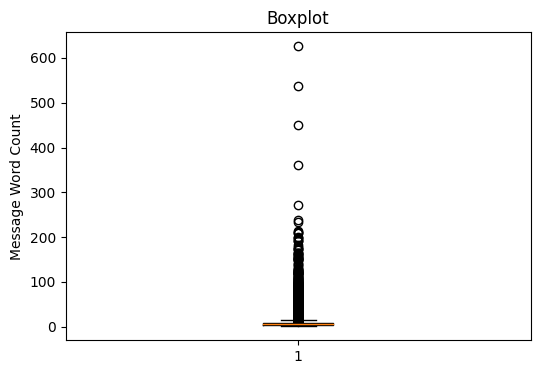

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def count_words(message):
    words = message.split()
    return len(words)

sampled_df['message_word_count'] = sampled_df['message'].apply(count_words)

plt.figure(figsize=(6, 4))
plt.boxplot(sampled_df['message_word_count'])
plt.title('Boxplot')
plt.ylabel('Message Word Count')
plt.show()

q1 = sampled_df['message_word_count'].quantile(0.25)
q3 = sampled_df['message_word_count'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = sampled_df[(sampled_df['message_word_count'] < lower_bound) | (sampled_df['message_word_count'] > upper_bound)]

sampled_df = sampled_df[~sampled_df.index.isin(outliers.index)]
sampled_df = sampled_df.drop(columns=['message_word_count'])


In [ ]:
def is_empty_or_space(s):
    return s == '' or s == ' '

sampled_df = sampled_df[~sampled_df['message'].apply(is_empty_or_space)]

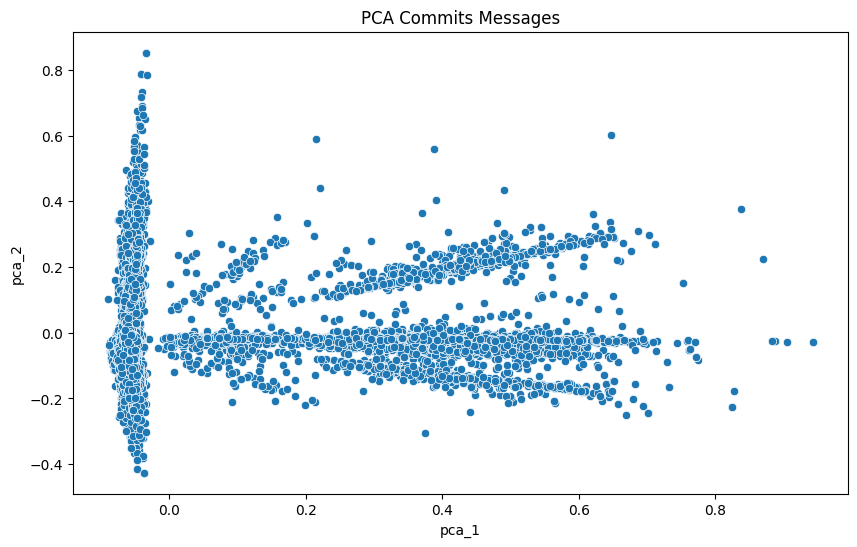

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_df["message"])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
sampled_df["pca_1"] = pca_result[:, 0]
sampled_df["pca_2"] = pca_result[:, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_df, x="pca_1", y="pca_2")
plt.title("PCA Commits Messages")
plt.show()

In [ ]:
sampled_df.shape

(33817, 6)

In [ ]:
df_filtrado = sampled_df[sampled_df['message_old'] != sampled_df['message']]
df_resultado = df_filtrado[['message_old', 'message']]
df_resultado.head(10)

message_old  \
0   upgraded compile-time dependency to EHCache 2....   
1   Polish validation in RequestBodyArgumentResolv...   
2    Polishing\n(cherry picked from commit 77e00f1)\n   
3   Register JndiPropertySource by default in port...   
4    Add logging to randomly failing websocket test\n   
6   Merge pull request #485 from cbaldwin74/SPR-95...   
7   Bump protobuf to restore Android compatibility...   
8   BeanUtils.getResolvableConstructor falls back ...   
9   Merge branch '5.3.x'\n\n# Conflicts:\n#\t.mail...   
10  [SPR-5713] Added 'value' alias for @ContextCon...   

                                              message  
0                                              depend  
1                                        polish valid  
2                                         pick commit  
3                              regist default portlet  
4                          add log randomli fail test  
6            merg pull request script support support  
7   bump restor android compat bump restor android...  
8                              back singl constructor  
9                                         merg branch  
10                                            ad alia

In [ ]:
df_filtrado = sampled_df[sampled_df['message_old'] != sampled_df['message']]
df_resultado = df_filtrado[['lang', 'stars', 'message']]
df_resultado.sample(10)

lang   stars                                            message
33287         PHP   12243                            adjust token count emul
27786         PHP   15571                                       use argument
33211         PHP   15571                         append abstract class test
60031        Ruby   27765                               ad throw except fail
39968      Python   41190                    fix resolv redirect pass origin
20603  JavaScript   57134                                     add test valid
59728        Ruby   27765                               ensur right platform
5964         Java   34507  add simpl handl commit support simpl handler p...
24071  JavaScript  137905         updat copyright match add repositori refer
23656  JavaScript   57134           make sure head browser page fix upstream

In [ ]:
df_resultado["stars"] = df_resultado["stars"].astype(int)

df_resultado["popularity"] = pd.qcut(df_resultado["stars"], q=3, labels=["low", "medium", "high"])



<ipython-input-26-ba81e1b103bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado["stars"] = df_resultado["stars"].astype(int)
<ipython-input-26-ba81e1b103bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado["popularity"] = pd.qcut(df_resultado["stars"], q=3, labels=["low", "medium", "high"])


In [ ]:
df_resultado.sample(10)

lang   stars                                         message  \
61616        Ruby   27765                               remov migrat guid   
22397  JavaScript   57134                          use test runner instal   
54042        Ruby   44769         merg pull request add notic migrat guid   
48888      Python   42966               merg pull request ad interpret ai   
54187        Ruby   20434  ad note stop spring necessari stop spring rout   
61047        Ruby   27765                remov unnecessari disabl comment   
15366  JavaScript  137905                                       fix activ   
4563         Java   34507                               add code test see   
25957  JavaScript   68177         fix stale bot fix stale bot fix multipl   
34940         PHP   16555                      updat latest compos syntax   

      popularity  
61616        low  
22397       high  
54042     medium  
48888     medium  
54187        low  
61047        low  
15366       high  
4563      medium  
25957       high  
34940        low

# Clustering

## K-means (particionamento)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
df = sampled_df.copy()
df = df.drop(columns=['stars', 'lang'])

cotovelo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 1, WCSS: 33289.10
Number of Clusters: 2, WCSS: 32502.92
Number of Clusters: 3, WCSS: 32199.44
Number of Clusters: 4, WCSS: 31972.75


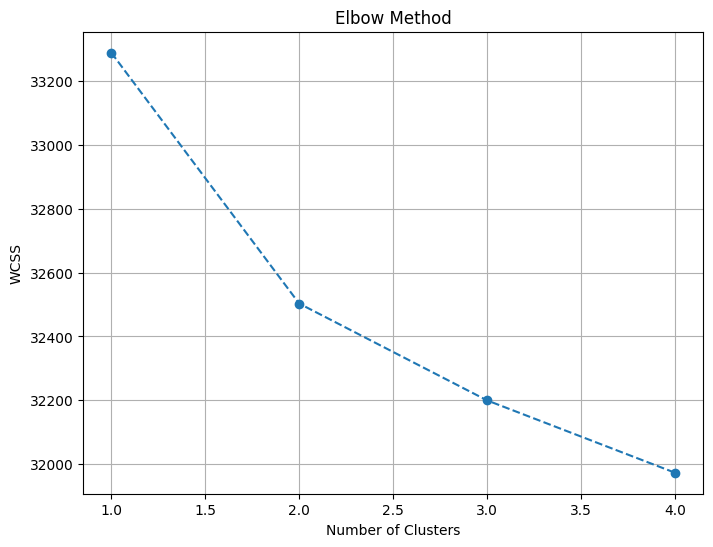

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['message'])
wcss = []
for i in range(1, 5):
    kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++')
    kmeans.fit(tfidf_matrix)
    wcss_value = kmeans.inertia_
    wcss.append(wcss_value)
    print(f'Number of Clusters: {i}, WCSS: {wcss_value:.2f}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, 5), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

aplicando

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 2
num_init = 20

kmeans = KMeans(n_clusters=num_clusters, n_init=num_init, random_state=100, init='k-means++')
kmeans.fit(tfidf_matrix)

df['cluster_label'] = kmeans.labels_
print(df['cluster_label'].value_counts())
print(df.head())


0    29866
1     3951
Name: cluster_label, dtype: int64
                                         message_old  \
0  upgraded compile-time dependency to EHCache 2....   
1  Polish validation in RequestBodyArgumentResolv...   
2   Polishing\n(cherry picked from commit 77e00f1)\n   
3  Register JndiPropertySource by default in port...   
4   Add logging to randomly failing websocket test\n   

                      message     pca_1     pca_2  cluster_label  
0                      depend -0.057703 -0.019905              0  
1                polish valid -0.053962 -0.012516              0  
2                 pick commit -0.065871 -0.018440              0  
3      regist default portlet -0.055998 -0.014509              0  
4  add log randomli fail test -0.059772 -0.103307              0  


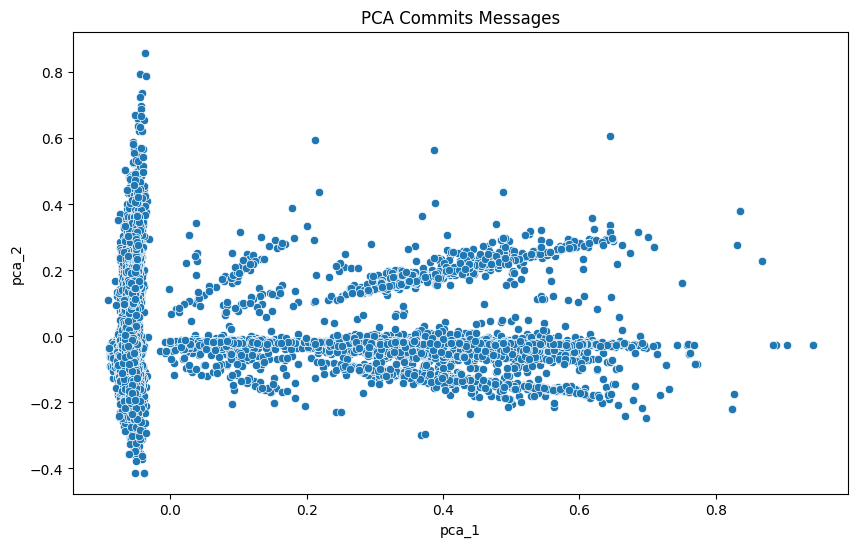

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


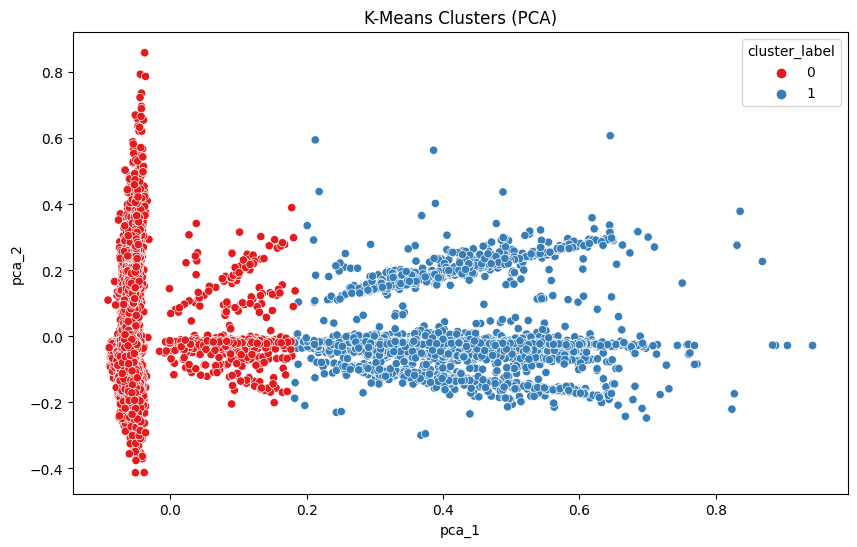

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Realize a redução de dimensionalidade usando PCA

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['message'])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Crie um DataFrame com os resultados do PCA
df["pca_1"] = pca_result[:, 0]
df["pca_2"] = pca_result[:, 1]

# Visualize os dados no espaço de duas dimensões
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2")
plt.title("PCA Commits Messages")
plt.show()

# Aplique o K-Means para identificar os clusters
kmeans = KMeans(n_clusters=2,  random_state=42, init='k-means++')  # Defina o número de clusters
df["cluster_label"] = kmeans.fit_predict(pca_result)

# Visualize os clusters identificados pelo K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="cluster_label", palette="Set1")
plt.title("K-Means Clusters (PCA)")
plt.show()


#### Pos processamento

PCA

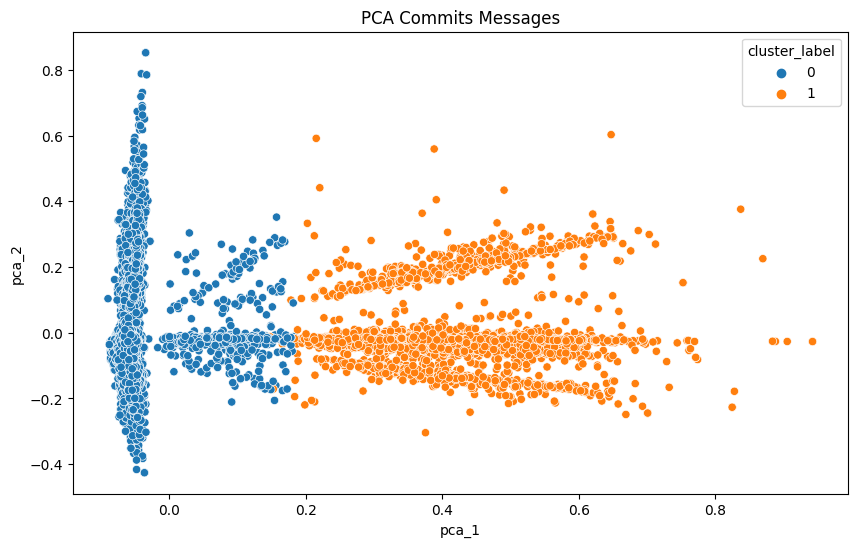

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["message"])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
df["pca_1"] = pca_result[:, 0]
df["pca_2"] = pca_result[:, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="cluster_label")
plt.title("PCA Commits Messages")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

pca_data = df[["pca_1", "pca_2"]]
cluster_labels = df["cluster_label"]

silhouette_avg = silhouette_score(pca_data, cluster_labels)
davies_bouldin = davies_bouldin_score(pca_data, cluster_labels)
calinski_harabas = calinski_harabasz_score(pca_data, cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Score: {calinski_harabas}")



Silhouette Score: 0.7690208868805086
Davies-Bouldin Score: 0.4253430982580026
Calinski-Harabasz Score: 56727.549379875134


## Hierarquico (baseado em vizinhança)


nao deu muito certo porque ao realizar a vetorização, ficam muitas features, o que nao é muito bom quando se trata de classificacao hierarquica. Simmplesmente inviavel rodar no minimo uma vez

In [ ]:
df = sampled_df.copy()
df = df.drop(columns=['stars', 'lang'])

truncando o dendograma para nao estourar a execucao

KeyboardInterrupt: ignored

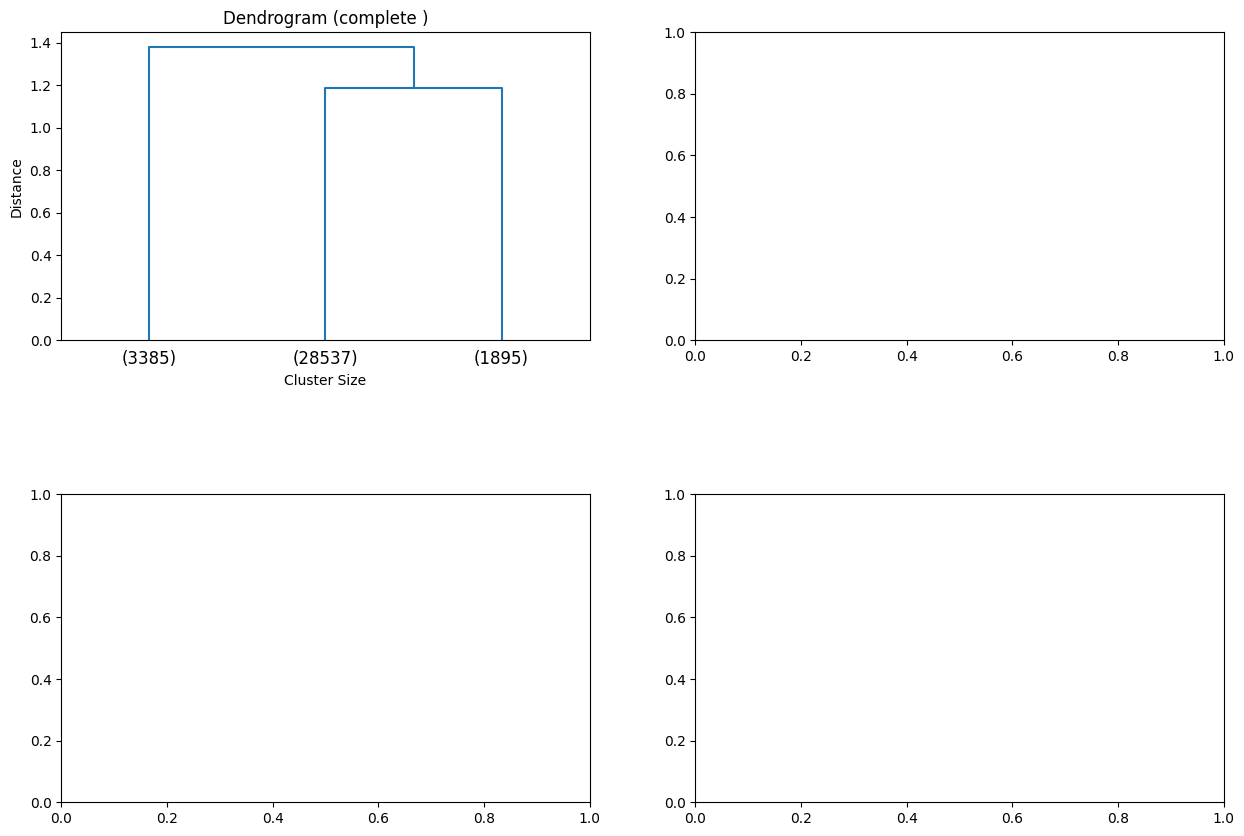

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

# Amostragem de dados
#sample_size = 6000
#df = df.sample(n=sample_size, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['message'])

tfidf_matrix_dense = tfidf_matrix.toarray()

n_components = 2
pca = PCA(n_components=n_components)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix_dense)

linkage_methods = ['complete', 'average', 'single', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

num_clusters = 3
for i, linkage_method in enumerate(linkage_methods):
    agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage_method)
    cluster_labels = agg_clustering.fit_predict(tfidf_matrix_reduced)

    df[f'cluster_label_{linkage_method}'] = cluster_labels

    ax = axes[i // 2, i % 2]
    linkage_matrix = linkage(tfidf_matrix_reduced, method=linkage_method)
    dendrogram(linkage_matrix, ax=ax, truncate_mode='lastp',  p=num_clusters)
    ax.set_title(f'Dendrogram ({linkage_method} )')
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()


In [ ]:
import sys
sys.setrecursionlimit(10000)

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

sample_size = 10000
df = df.sample(n=sample_size, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['message'])

tfidf_matrix_dense = tfidf_matrix.toarray()

n_components = 2
pca = PCA(n_components=n_components)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix_dense)

linkage_methods = ['complete', 'average', 'single', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

for i, linkage_method in enumerate(linkage_methods):
    ax = axes[i // 2, i % 2]
    linkage_matrix = linkage(tfidf_matrix_reduced, method=linkage_method)
    dendrogram(linkage_matrix, ax=ax)
    ax.set_title(f'Dendrogram ({linkage_method} )')
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()


### Pos processamento


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [ ]:
# pca para poder visualizar 2D
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["message"])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
df["pca_1"] = pca_result[:, 0]
df["pca_2"] = pca_result[:, 1]

linkage_methods = ['complete', 'average', 'single', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

pca_data = df[["pca_1", "pca_2"]]

for i, linkage_method in enumerate(linkage_methods):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(data=df, x="pca_1", y="pca_2", hue=f"cluster_label_{linkage_method}", ax=ax)
    ax.set_title(f'PCA Commits Messages - linkage {linkage_method}')

    cluster_labels = df[f"cluster_label_{linkage_method}"]
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    davies_bouldin = davies_bouldin_score(pca_data, cluster_labels)
    calinski_harabas = calinski_harabasz_score(pca_data, cluster_labels)
    print('-----')
    print(linkage_method)
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Score: {davies_bouldin}")
    print(f"Calinski-Harabasz Score: {calinski_harabas}")

# Ajuste o layout
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


word_counts_by_cluster = {}
clusters = df['cluster_label_ward'].unique()

for cluster in clusters:
    cluster_data = df[df['cluster_label_ward'] == cluster]
    all_words = ' '.join(cluster_data['message']).split()
    word_counts = pd.Series(all_words).value_counts()
    word_counts_by_cluster[cluster] = word_counts

top_n = 10

for cluster, word_counts in word_counts_by_cluster.items():
    plt.figure(figsize=(5, 3))
    top_words = word_counts.head(top_n)
    top_words.plot(kind='barh', color='skyblue')
    plt.xlabel('Register quantity')
    plt.ylabel('Words')
    plt.title(f'Mos frequent words in cluster {cluster}')
    plt.show()


## DBSCAN (densidade)


também nao foi muito bom por conta da forma que ele opera - a forma que estao dispostos os dados mais agrupados mesmo aplicando PCA

In [ ]:
sampled_df.shape

(33817, 6)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
df = sampled_df.copy()
#df = df.drop(columns=['stars', 'lang'])

# Amostragem
#sample_size = 15000
#df = df.sample(n=sample_size, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['message'])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
df["pca_1"] = pca_result[:, 0]
df["pca_2"] = pca_result[:, 1]

Refinando hiperparametros

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

min_samples_list = range(10, 20)
eps_values = [0.02 + i * 0.001 for i in range(int((0.03 - 0.02) / 0.001) + 1)]
best_eps = None
best_silhouette_score = -1
min_samples_final = 0
data = df[['pca_1', 'pca_2']]

for min_samples in min_samples_list:
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(data)
        unique_labels = set(cluster_labels)
        if len(unique_labels) <= 2:
            continue

        silhouette_avg = silhouette_score(data, cluster_labels)

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            min_samples_final = min_samples

print(f"min_samples={min_samples_final} eps={best_eps}")


min_samples=18 eps=0.023


In [ ]:
print(best_silhouette_score)

0.7146536676396122


Aplicando hiperparametros

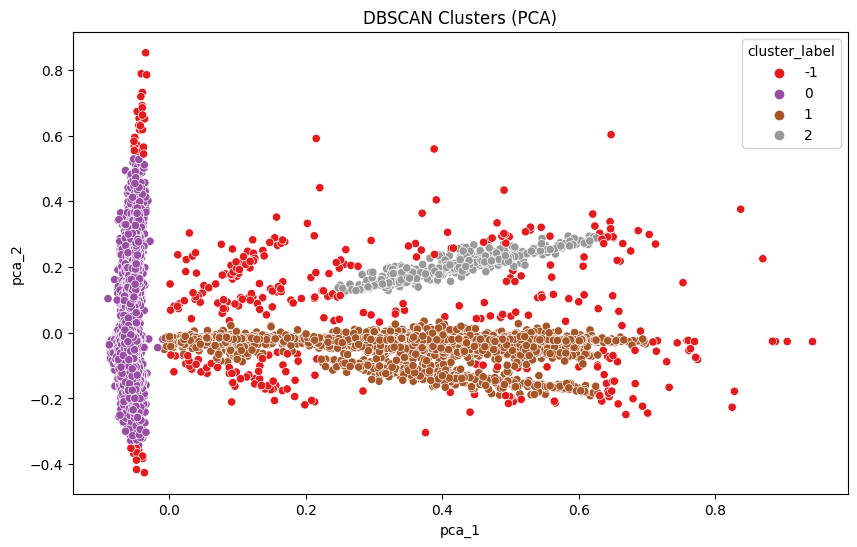

<ipython-input-45-67a545bc9906>:16: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.scatterplot(data=df_filtered, x="pca_1", y="pca_2", hue="cluster_label", palette=custom_palette)


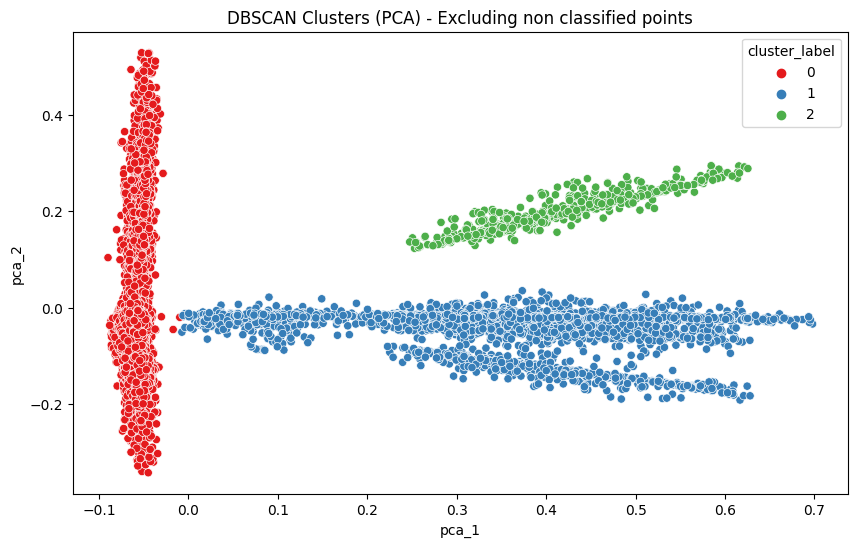

In [ ]:
#dbscan = DBSCAN(eps=0.027, min_samples=20)
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples_final)
df['cluster_label'] = dbscan.fit_predict(pca_result)

plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette("Set1", as_cmap=True)
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="cluster_label", palette=custom_palette)
plt.title("DBSCAN Clusters (PCA)")
plt.show()

df_filtered = df[df['cluster_label'] != -1]

custom_palette = sns.color_palette("Set1", as_cmap=False)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="pca_1", y="pca_2", hue="cluster_label", palette=custom_palette)
plt.title("DBSCAN Clusters (PCA) - Excluding non classified points")
plt.show()


In [ ]:
print(df['cluster_label'].value_counts())

 0    29267
 1     3603
 2      537
-1      410
Name: cluster_label, dtype: int64


In [ ]:
import pandas as pd
from collections import Counter

cluster_sizes = dict(Counter(df['cluster_label']))

clusters_to_remove = [cluster for cluster, size in cluster_sizes.items() if size < 30]
df_final = df[~df['cluster_label'].isin(clusters_to_remove)]

In [ ]:
df_final = df_final[df_final['cluster_label'] != -1]

<ipython-input-49-dd462d0f385f>:2: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x="pca_1", y="pca_2", hue="cluster_label", palette=custom_palette)


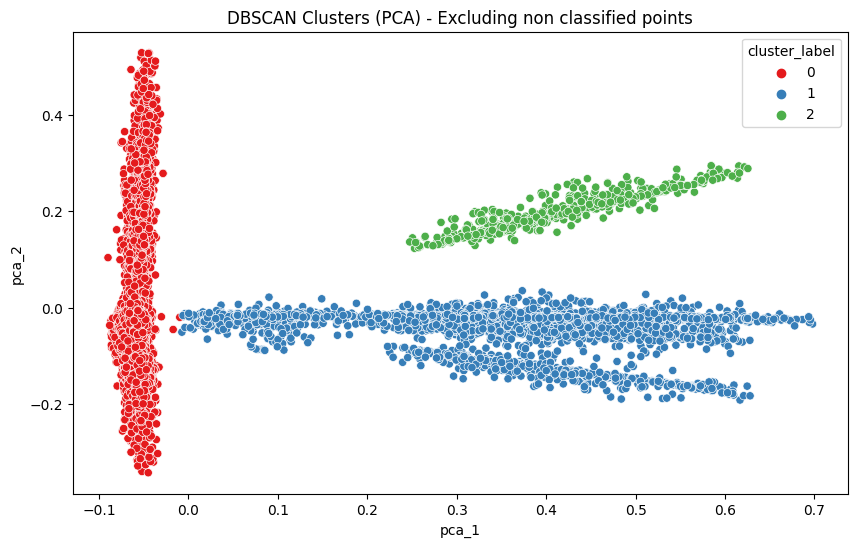

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="pca_1", y="pca_2", hue="cluster_label", palette=custom_palette)
plt.title("DBSCAN Clusters (PCA) - Excluding non classified points")
plt.show()


# Pós Processamento

In [ ]:
mapping = {0: 'fix/add', 1: 'merge/pull add', 2: 'merge/pull fix'}
df_final['cluster_label'] = df_final['cluster_label'].replace(mapping)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

pca_data = df_final[["pca_1", "pca_2"]]
cluster_labels = df_final["cluster_label"]

silhouette_avg = silhouette_score(pca_data, cluster_labels)
davies_bouldin = davies_bouldin_score(pca_data, cluster_labels)
calinski_harabas = calinski_harabasz_score(pca_data, cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Score: {calinski_harabas}")



Silhouette Score: 0.730997849665989
Davies-Bouldin Score: 0.6961389856086765
Calinski-Harabasz Score: 29496.111442138055


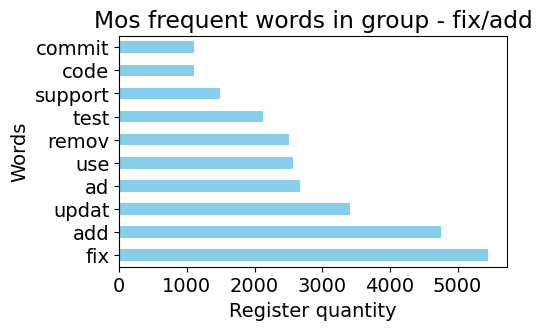

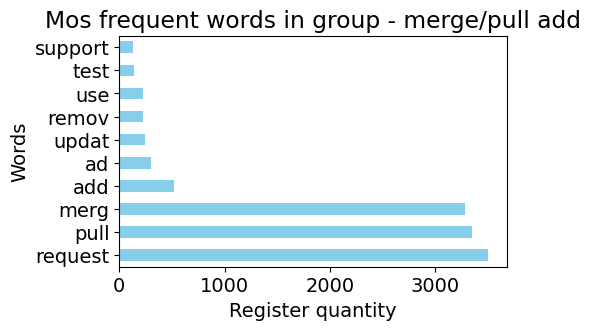

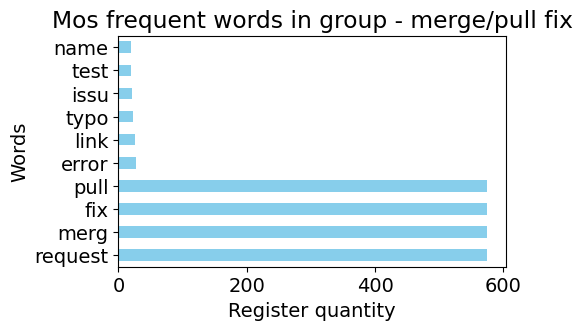

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


word_counts_by_cluster = {}
clusters = df_final['cluster_label'].unique()

for cluster in clusters:
    cluster_data = df_final[df_final['cluster_label'] == cluster]
    all_words = ' '.join(cluster_data['message']).split()
    word_counts = pd.Series(all_words).value_counts()
    word_counts_by_cluster[cluster] = word_counts

top_n = 10

for cluster, word_counts in word_counts_by_cluster.items():
    plt.figure(figsize=(5, 3))
    top_words = word_counts.head(top_n)
    top_words.plot(kind='barh', color='skyblue')
    plt.xlabel('Register quantity')
    plt.ylabel('Words')
    plt.title(f'Mos frequent words in group - {cluster}')
    plt.show()


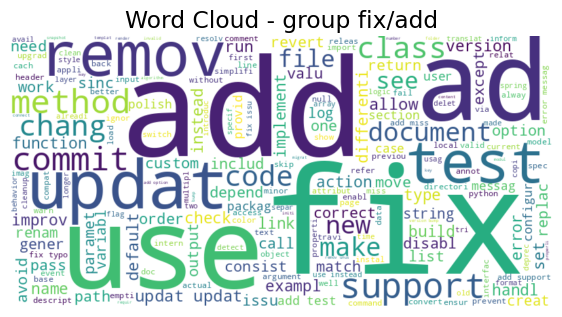

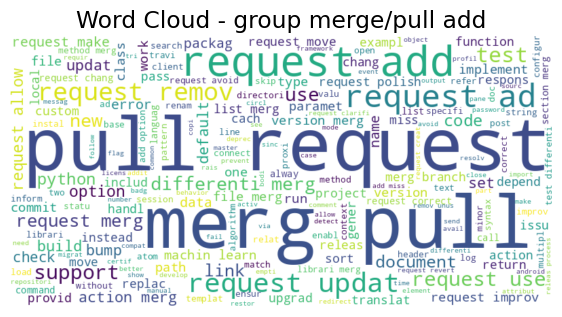

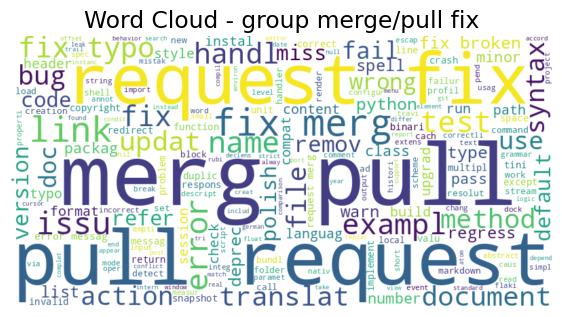

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

clusters = df_final['cluster_label'].unique()

wordcloud = WordCloud(width=800, height=400, background_color='white')

for cluster in clusters:
    messages_in_cluster = df_final[df_final['cluster_label'] == cluster]['message']
    text = ' '.join(messages_in_cluster)
    wordcloud.generate(text)

    plt.figure(figsize=(7, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - group {cluster}')
    plt.axis('off')
    plt.show()


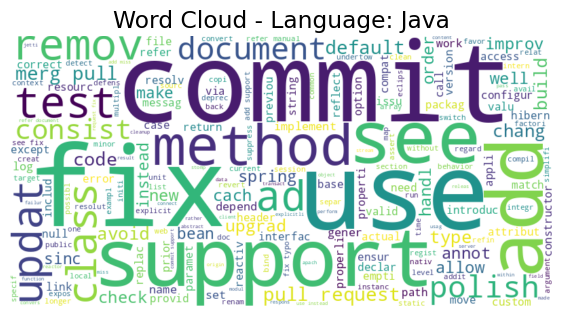

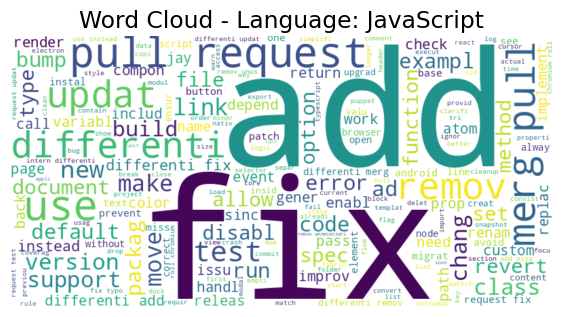

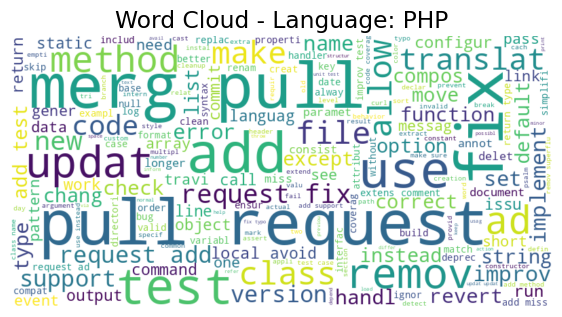

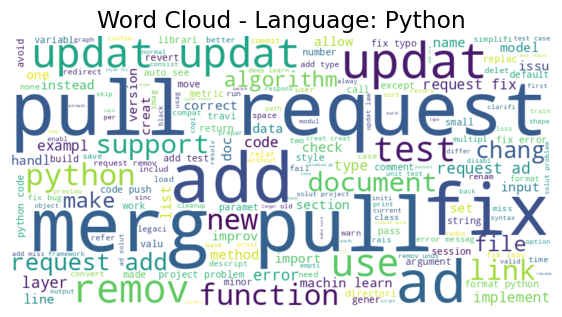

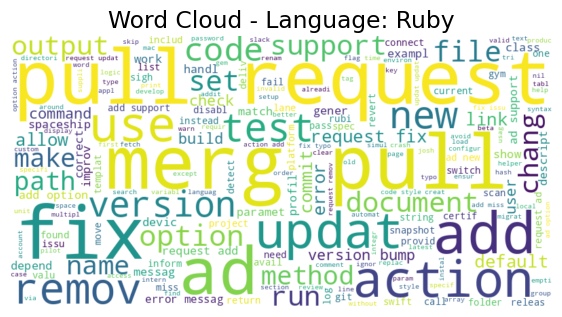

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_languages = df_final['lang'].unique()

wordcloud = WordCloud(width=800, height=400, background_color='white')

for lang in unique_languages:
    messages_in_lang = df_final[df_final['lang'] == lang]['message']
    text = ' '.join(messages_in_lang)
    wordcloud.generate(text)

    plt.figure(figsize=(7, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Language: {lang}')
    plt.axis('off')
    plt.show()


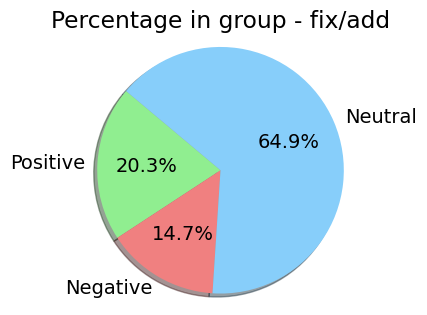

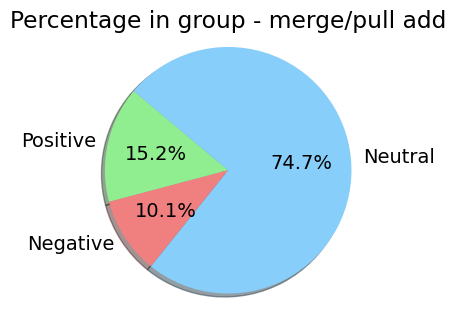

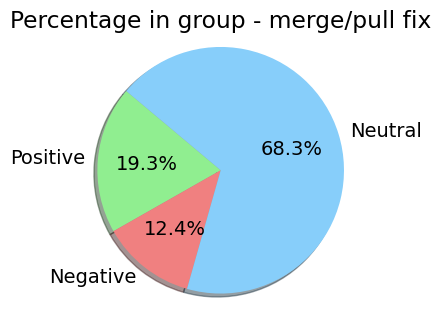

In [ ]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt


def calcular_sentimento(mensagem):
    analysis = TextBlob(mensagem)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity == 0:
        return "Neutral"
    else:
        return "Negative"

df_final['sentiment'] = df_final['message_old'].apply(calcular_sentimento)


clusters = df_final['cluster_label'].unique()

colors = ['lightgreen', 'lightcoral', 'lightskyblue']

plt.rcParams.update({'font.size': 14})

for cluster in clusters:
    cluster_df = df_final[df_final['cluster_label'] == cluster]

    positive_count = (cluster_df['sentiment'] == 'Positive').sum()
    negative_count = (cluster_df['sentiment'] == 'Negative').sum()
    neutral_count = (cluster_df['sentiment'] == 'Neutral').sum()

    total_sentiments = len(cluster_df)

    positive_percentage = (positive_count / total_sentiments) * 100
    negative_percentage = (negative_count / total_sentiments) * 100
    neutral_percentage = (neutral_count / total_sentiments) * 100

    labels = ['Positive', 'Negative', 'Neutral']
    sizes = [positive_percentage, negative_percentage, neutral_percentage]

    plt.figure(figsize=(3.5, 3.5))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title(f"Percentage in group - {cluster}")
    plt.show()


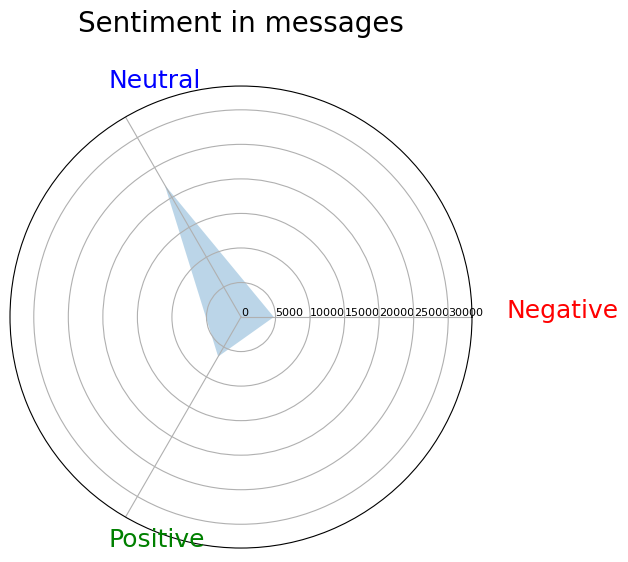

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = df_final.copy()

sentiments = ['Negative', 'Neutral', 'Positive']

values = [len(df[df['sentiment'] == 'Negative']), len(df[df['sentiment'] == 'Neutral']), len(df[df['sentiment'] == 'Positive'])]

categories = sentiments
N = len(categories)
values += values[:1]
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
category_colors = ['red', 'green', 'blue']
plt.xticks(angles[:-1], ['','',''])
plt.text(angles[0], len(df) + 5000,'Negative', color='red', size=18)
plt.text(angles[1], len(df) + 5000,'Neutral', color='blue', size=18)
plt.text(angles[2], len(df) + 5000,'Positive', color='green', size=18)
ax.set_rlabel_position(0)
plt.yticks(range(0, len(df), 5000), [str(x) for x in range(0, len(df), 5000)], color='black', size=8)
plt.ylim(0, len(df))
ax.fill(angles, values, 'p', alpha=0.3)
plt.title("Sentiment in messages", size=20, y=1.1)
plt.show()

sampled_df = df.copy()


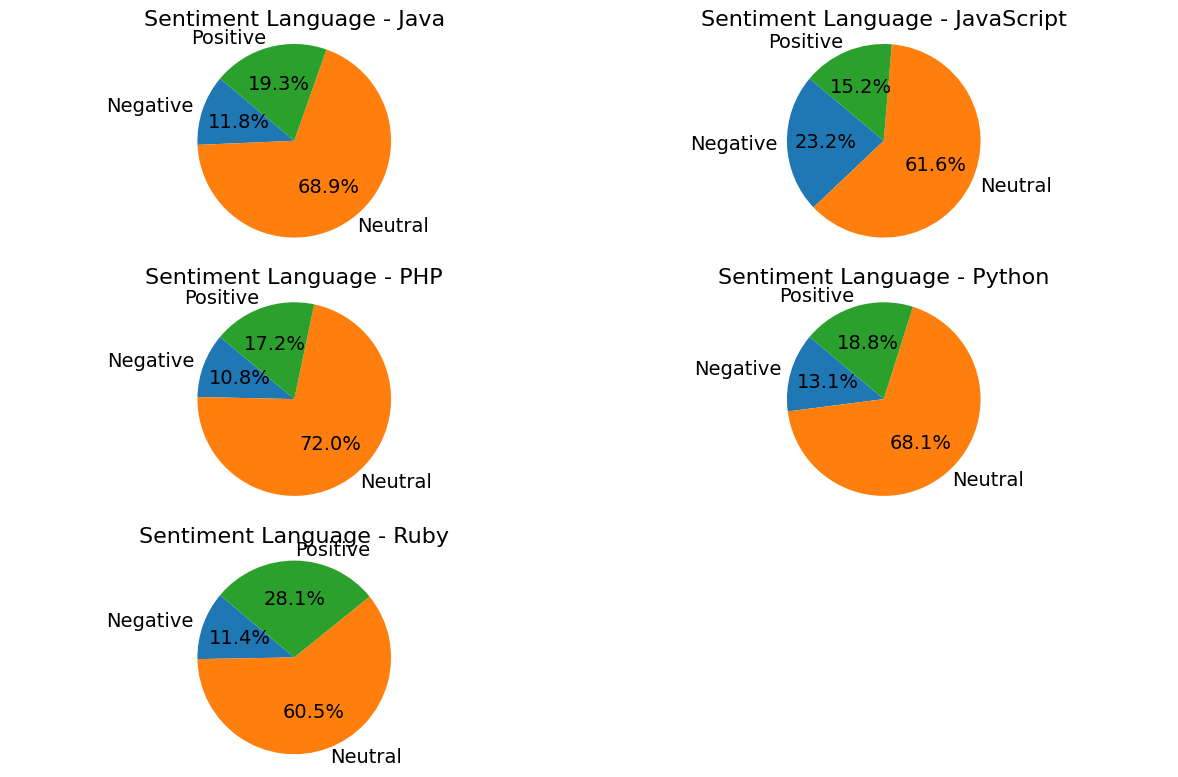

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sentimento_por_linguagem = df_final.groupby('lang')['sentiment'].value_counts().unstack().fillna(0)

sentimento_por_linguagem_percent = sentimento_por_linguagem.div(sentimento_por_linguagem.sum(axis=1), axis=0) * 100

num_languages = len(sentimento_por_linguagem_percent.index)
num_cols = 2
num_rows = int(np.ceil(num_languages / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, lang in enumerate(sentimento_por_linguagem_percent.index):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]

    pie_params = ax.pie(sentimento_por_linguagem_percent.loc[lang], labels=sentimento_por_linguagem_percent.columns, autopct='%1.1f%%', startangle=140,
                        textprops={'fontsize': 14})

    title = f'Sentiment Language - {lang}'
    ax.set_title(title, fontsize=16)
    ax.axis('equal')

for i in range(num_languages, num_rows * num_cols):
    fig.delaxes(axes[divmod(i, num_cols)])

plt.tight_layout()
plt.show()


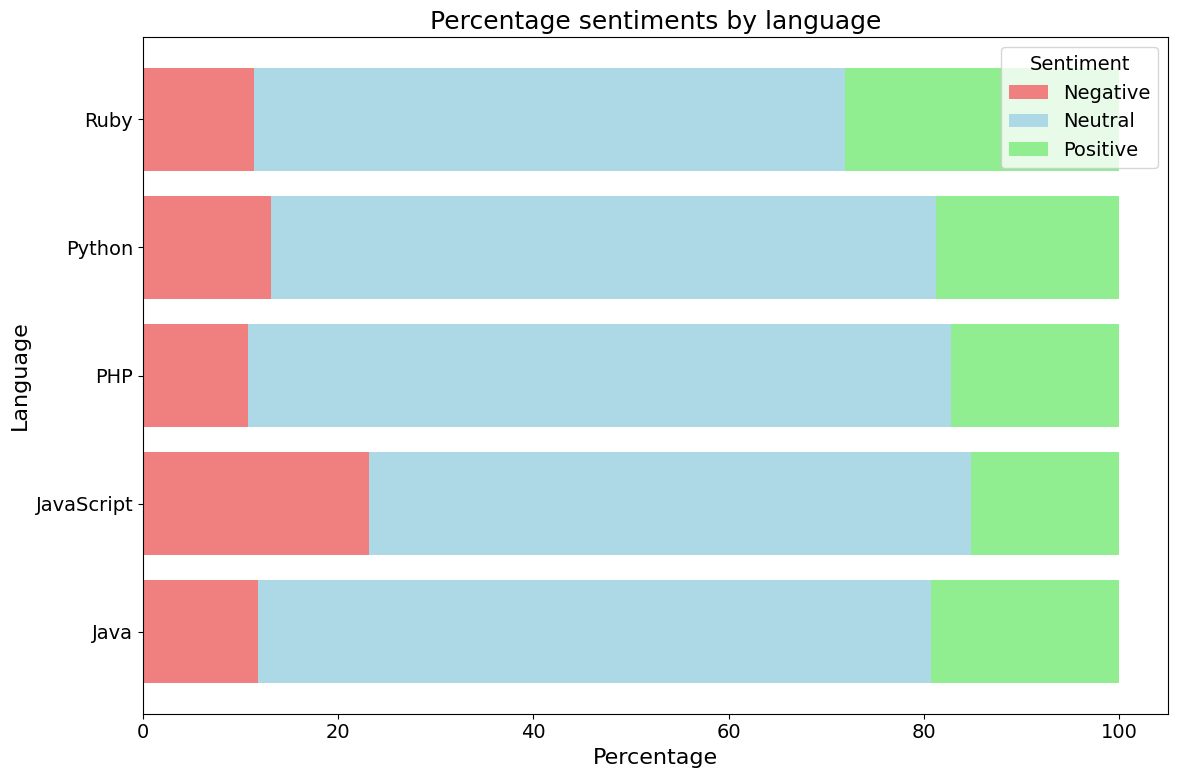

In [ ]:
import matplotlib.pyplot as plt

sentimento_por_linguagem = df_final.groupby('lang')['sentiment'].value_counts().unstack().fillna(0)

sentimento_por_linguagem_percent = sentimento_por_linguagem.div(sentimento_por_linguagem.sum(axis=1), axis=0) * 100

sentimento_por_linguagem_percent = sentimento_por_linguagem_percent.T

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['lightcoral', 'lightblue', 'lightgreen']
bottom = [0] * len(sentimento_por_linguagem_percent.columns)

for sentiment, color in zip(sentimento_por_linguagem_percent.index, colors):
    ax.barh(sentimento_por_linguagem_percent.columns, sentimento_por_linguagem_percent.loc[sentiment], left=bottom, color=color, label=sentiment)
    bottom = [bottom[i] + sentimento_por_linguagem_percent.loc[sentiment][i] for i in range(len(bottom))]

ax.set_xlabel('Percentage', fontsize=16)
ax.set_ylabel('Language', fontsize=16)
ax.set_title('Percentage sentiments by language', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title='Sentiment', fontsize=14)

plt.tight_layout()
plt.show()


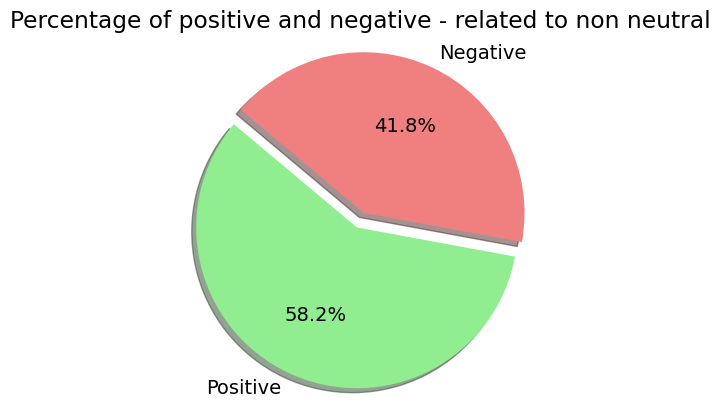

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

non_neutral_df = df[df['sentiment'] != 'neutro']

positive_count = (non_neutral_df['sentiment'] == 'Positive').sum()
negative_count = (non_neutral_df['sentiment'] == 'Negative').sum()

total_non_neutral = len(non_neutral_df)
positive_percentage = (positive_count / total_non_neutral) * 100
negative_percentage = (negative_count / total_non_neutral) * 100

labels = ['Positive', 'Negative']
sizes = [positive_percentage, negative_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

plt.title("Percentage of positive and negative - related to non neutral")

plt.show()


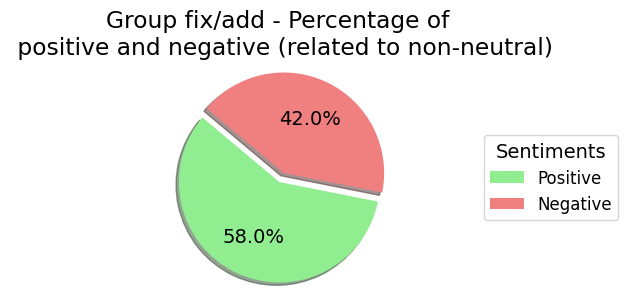

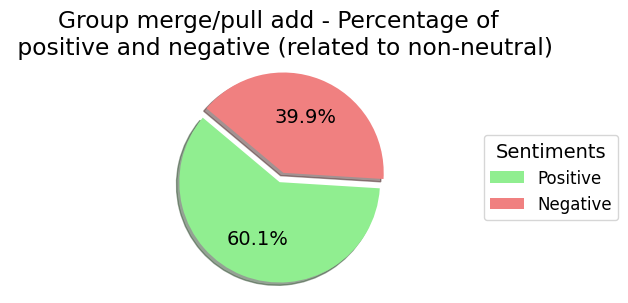

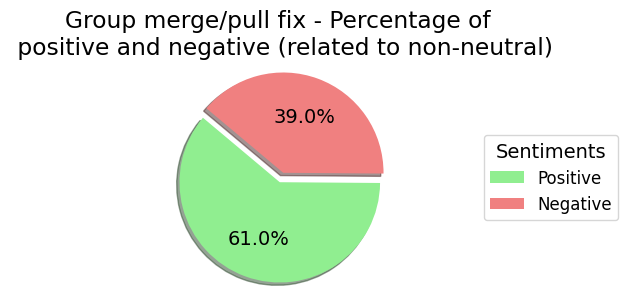

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

unique_clusters = df['cluster_label'].unique()

fig_size = (5, 3)
for cluster in unique_clusters:
    cluster_df = df[df['cluster_label'] == cluster]

    non_neutral_df = cluster_df[cluster_df['sentiment'] != 'neutro']

    positive_count = (non_neutral_df['sentiment'] == 'Positive').sum()
    negative_count = (non_neutral_df['sentiment'] == 'Negative').sum()

    total_non_neutral = len(non_neutral_df)
    positive_percentage = (positive_count / total_non_neutral) * 100
    negative_percentage = (negative_count / total_non_neutral) * 100

    labels = ['Positive', 'Negative']
    sizes = [positive_percentage, negative_percentage]
    colors = ['lightgreen', 'lightcoral']
    explode = (0.1, 0)

    plt.figure(figsize=fig_size)

    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')

    plt.title(f"Group {cluster} - Percentage of \n positive and negative (related to non-neutral)")

    legend = plt.legend(labels, title="Sentiments", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.setp(legend.get_title(), fontsize=14)
    plt.show()


<ipython-input-36-bac5d07fcf9b>:23: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  parallel_coordinates(df, 'Method', colormap='cool', color=colors)


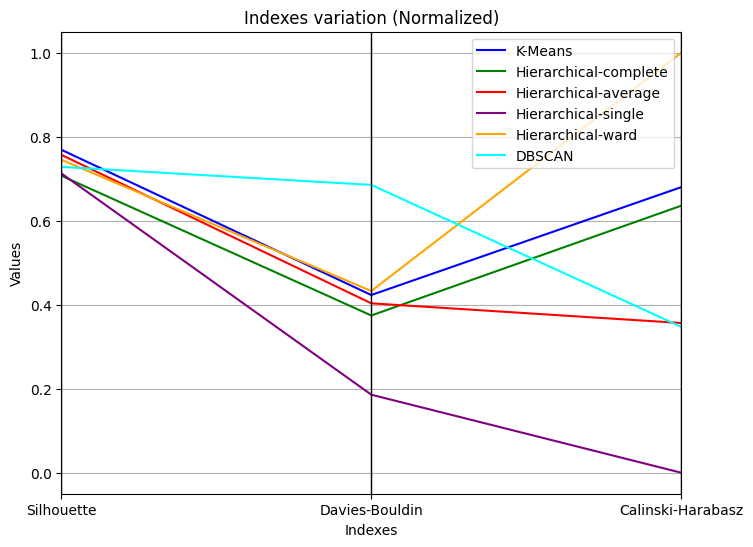

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler

data = {
    'Method': ['K-Means', 'Hierarchical-complete', 'Hierarchical-average', 'Hierarchical-single', 'Hierarchical-ward', 'DBSCAN'],
    'Silhouette': [0.7690032126597708, 0.7073071468844329, 0.7569142281858051, 0.7128011003970675, 0.7450050233258273, 0.7282524772749389],
    'Davies-Bouldin': [0.42312409662002204, 0.37438748250762927, 0.4033425885991669, 0.18581342486904606, 0.43270164210002476, 0.6853322316673104],
    'Calinski-Harabasz': [57002.85376480303, 53299.65276677416, 29888.8858093216, 17.56927305990017, 83823.19355152907, 29126.34444322541]
}

df = pd.DataFrame(data)

columns_to_normalize = ['Calinski-Harabasz']

scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']

plt.figure(figsize=(8, 6))
parallel_coordinates(df, 'Method', colormap='cool', color=colors)
plt.title('Indexes variation (Normalized)')
plt.xlabel('Indexes')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.show()


In [ ]:
df_final.head()

lang  stars                                        message_old  \
4  Java  34507                 Upgrade CI image to jdk8u265-b01\n   
6  Java  34507  Added "entityResolver", "classDescriptorResolv...   
7  Java  34507  Consistent nullability in DataAccessUtils thro...   
8  Java  25825                                    see 04/08 log\n   
9  Java  34507            Support HTTP HEAD\n\nIssue: SPR-13130\n   

                  message     pca_1     pca_2 cluster_label sentiment  
4             upgrad imag -0.057299 -0.012571       fix/add   Neutral  
6  ad also properti favor -0.060765 -0.043060       fix/add   Neutral  
7                 consist -0.063901 -0.019286       fix/add  Positive  
8                 see log -0.069250 -0.016009       fix/add   Neutral  
9            support head -0.056657 -0.061331       fix/add   Neutral

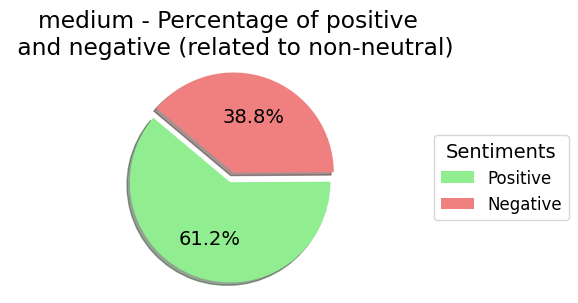

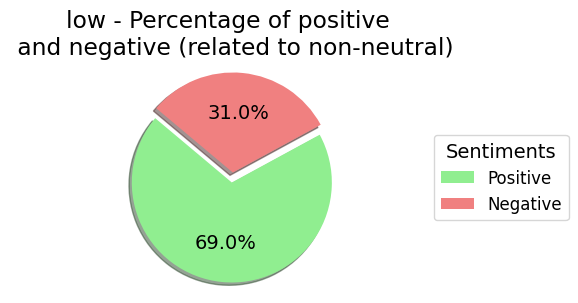

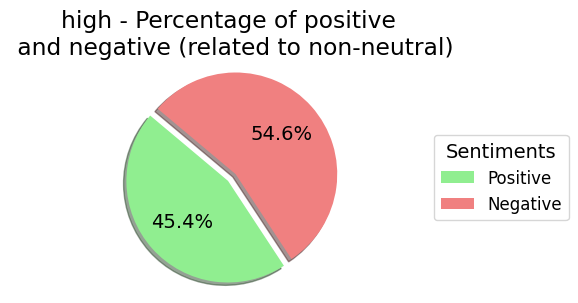

In [ ]:
import pandas as pd

df = df_final.copy()

df.dropna()
df["stars"] = df["stars"].astype(int)

df["popularity"] = pd.qcut(df["stars"], q=3, labels=["low", "medium", "high"])


import pandas as pd
import matplotlib.pyplot as plt

unique_clusters = df['popularity'].unique()

fig_size = (5, 3)
for cluster in unique_clusters:
    cluster_df = df[df['popularity'] == cluster]

    non_neutral_df = cluster_df[cluster_df['sentiment'] != 'neutral']

    positive_count = (non_neutral_df['sentiment'] == 'Positive').sum()
    negative_count = (non_neutral_df['sentiment'] == 'Negative').sum()

    total_non_neutral = len(non_neutral_df)
    positive_percentage = (positive_count / total_non_neutral) * 100
    negative_percentage = (negative_count / total_non_neutral) * 100

    labels = ['Positive', 'Negative']
    sizes = [positive_percentage, negative_percentage]
    colors = ['lightgreen', 'lightcoral']
    explode = (0.1, 0)

    plt.figure(figsize=fig_size)

    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')

    plt.title(f"{cluster} - Percentage of positive \n and negative (related to non-neutral)")

    legend = plt.legend(labels, title="Sentiments", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.setp(legend.get_title(), fontsize=14)
    plt.show()


<ipython-input-209-dffdc15b8bf0>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"popularity": popularity, "Positive": positive_percentage, "Negative": negative_percentage}, ignore_index=True)
<ipython-input-209-dffdc15b8bf0>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"popularity": popularity, "Positive": positive_percentage, "Negative": negative_percentage}, ignore_index=True)
<ipython-input-209-dffdc15b8bf0>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"popularity": popularity, "Positive": positive_percentage, "Negative": negative_percentage}, ignore_index=True)


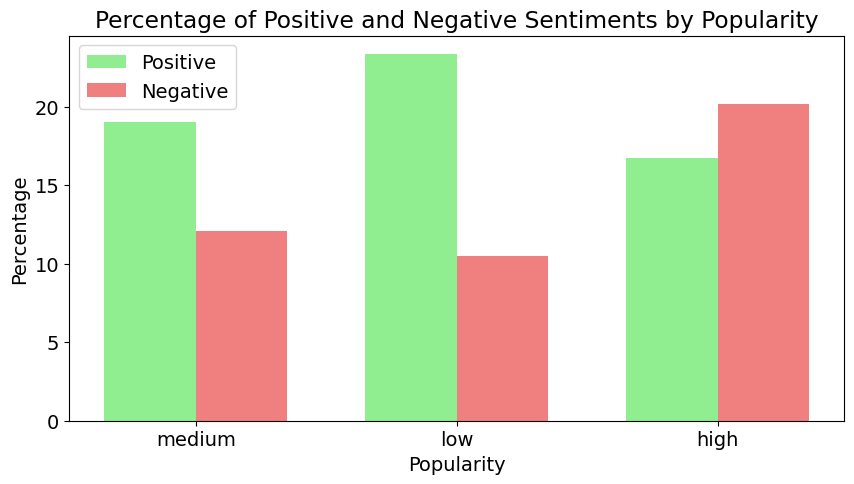

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_final.copy()
df.dropna()
df["stars"] = df["stars"].astype(int)

df["popularity"] = pd.qcut(df["stars"], q=3, labels=["low", "medium", "high"])

results = pd.DataFrame(columns=["popularity", "Positive", "Negative"])

unique_popularities = df['popularity'].unique()

for popularity in unique_popularities:
    popularity_df = df[df['popularity'] == popularity]
    non_neutral_df = popularity_df[popularity_df['sentiment'] != 'neutral']
    total_non_neutral = len(non_neutral_df)

    positive_count = (non_neutral_df['sentiment'] == 'Positive').sum()
    negative_count = (non_neutral_df['sentiment'] == 'Negative').sum()

    positive_percentage = (positive_count / total_non_neutral) * 100
    negative_percentage = (negative_count / total_non_neutral) * 100

    results = results.append({"popularity": popularity, "Positive": positive_percentage, "Negative": negative_percentage}, ignore_index=True)


fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.35
bar_positions = range(len(unique_popularities))

ax.bar(bar_positions, results['Positive'], bar_width, label='Positive', color='lightgreen')
ax.bar([pos + bar_width for pos in bar_positions], results['Negative'], bar_width, label='Negative', color='lightcoral')

ax.set_xlabel('Popularity')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Positive and Negative Sentiments by Popularity')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(unique_popularities)
ax.legend()

plt.show()


In [ ]:
df.head()

lang  stars                                        message_old  \
4  Java  34507                 Upgrade CI image to jdk8u265-b01\n   
6  Java  34507  Added "entityResolver", "classDescriptorResolv...   
7  Java  34507  Consistent nullability in DataAccessUtils thro...   
8  Java  25825                                    see 04/08 log\n   
9  Java  34507            Support HTTP HEAD\n\nIssue: SPR-13130\n   

                  message     pca_1     pca_2 cluster_label sentiment  \
4             upgrad imag -0.057299 -0.012571       fix/add   Neutral   
6  ad also properti favor -0.060765 -0.043060       fix/add   Neutral   
7                 consist -0.063901 -0.019286       fix/add  Positive   
8                 see log -0.069250 -0.016009       fix/add   Neutral   
9            support head -0.056657 -0.061331       fix/add   Neutral   

  popularity  
4     medium  
6     medium  
7     medium  
8        low  
9     medium

<ipython-input-226-cbac9ed9b2de>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(row, ignore_index=True)
<ipython-input-226-cbac9ed9b2de>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(row, ignore_index=True)
<ipython-input-226-cbac9ed9b2de>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(row, ignore_index=True)


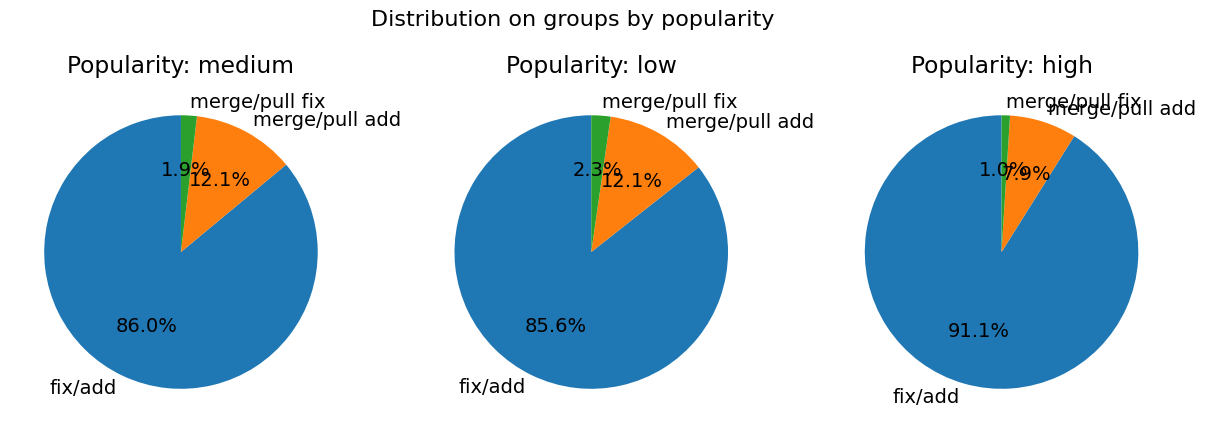

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Criação de um DataFrame para armazenar os resultados
results = pd.DataFrame(columns=['popularity'] + [f'{i}' for i in df['cluster_label'].unique()])

# Obtém as popularidades únicas
unique_popularities = df['popularity'].unique()

# Itera sobre as popularidades
for popularity in unique_popularities:
    popularity_df = df[df['popularity'] == popularity]

    # Calcula a porcentagem de cada cluster_label
    percentages = popularity_df['cluster_label'].value_counts(normalize=True) * 100

    # Preenche o DataFrame de resultados
    row = {'popularity': popularity}
    row.update({f'{i}': percentages.get(i, 0) for i in df['cluster_label'].unique()})
    results = results.append(row, ignore_index=True)

# Plotagem do gráfico de pizza para cada popularidade
fig, axs = plt.subplots(1, len(unique_popularities), figsize=(15, 5))
fig.suptitle('Distribution on groups by popularity', fontsize=16)

for i, popularity in enumerate(unique_popularities):
    labels = results.columns[1:]
    sizes = results.loc[results['popularity'] == popularity, labels].values.flatten()

    axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
    axs[i].set_title(f'Popularity: {popularity}')

plt.show()

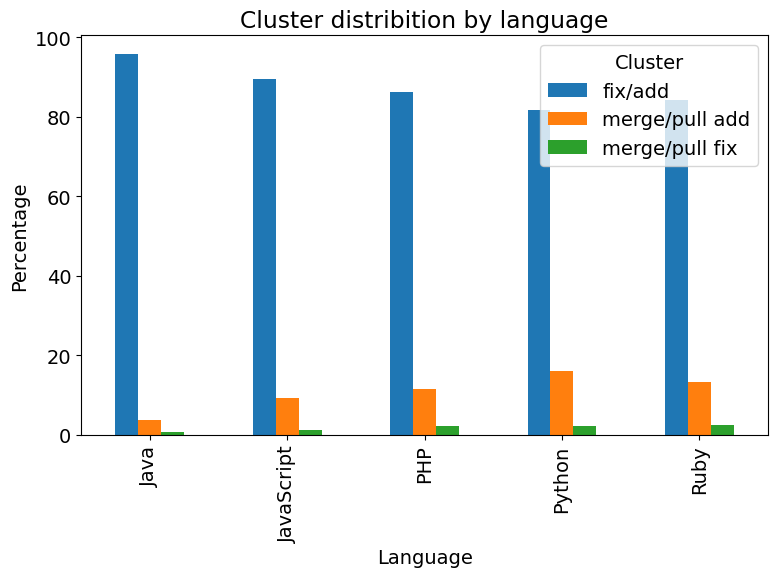

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = df_final[['cluster_label', 'lang']]

count_combinations = data.groupby(['lang', 'cluster_label']).size().reset_index(name='count')

count_combinations['total'] = count_combinations.groupby('lang')['count'].transform('sum')
count_combinations['percentage'] = (count_combinations['count'] / count_combinations['total']) * 100

pivot_table = count_combinations.pivot(index='lang', columns='cluster_label', values='percentage')

pivot_table.plot(kind='bar', figsize=(8, 6))

plt.title('Cluster distribition by language')
plt.xlabel('Language')
plt.ylabel('Percentage')

plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
